In [1]:
import numpy as np
from re import sub
import tensorflow as tf
import keras
from tensorflow.keras import metrics

import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.5
2.3.1


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [3]:
from tensorflow.keras.applications.mobilenet import preprocess_input

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('output/train',
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator=train_datagen.flow_from_directory('output/val',
                                                     target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 16132 images belonging to 26 classes.
Found 2009 images belonging to 26 classes.


In [4]:
classes = train_generator.class_indices
class_list = list(classes.keys())

In [5]:
class_list

['Alstonia_Scholaris',
 'Apple',
 'Arjun',
 'Background_without_leaves',
 'Bael',
 'Basil',
 'Blueberry',
 'Cherry',
 'Chinar',
 'Corn',
 'Gauva',
 'Grape',
 'Grapevine',
 'Jamun',
 'Jatropha',
 'Lemon',
 'Mango',
 'Peach',
 'Pepper',
 'Pomegranate',
 'Pongamia_Pinnata',
 'Potato',
 'Raspberry',
 'Soybean',
 'Strawberry',
 'Tomato']

In [6]:
base_model=tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(26,activation='softmax')(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model2=Model(inputs=base_model.input,outputs=preds)

In [8]:
for layer in model2.layers[:20]:
    layer.trainable=False
for layer in model2.layers[20:]:
    layer.trainable=True

In [9]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [10]:
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [12]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [13]:
step_size_train=train_generator.n//train_generator.batch_size
model2_history=model2.fit(train_generator,
                    validation_data =val_generator,
                   steps_per_epoch=step_size_train,
                   epochs=2)

Epoch 1/2
504/504 [==============================] - 1874s 4s/step - loss: 0.4313 - tp: 13729.0000 - fp: 1085.0000 - tn: 401415.0000 - fn: 2371.0000 - accuracy: 0.8841 - precision: 0.9268 - recall: 0.8527 - auc: 0.9901 - val_loss: 1.4946 - val_tp: 1279.0000 - val_fp: 511.0000 - val_tn: 49714.0000 - val_fn: 730.0000 - val_accuracy: 0.6680 - val_precision: 0.7145 - val_recall: 0.6366 - val_auc: 0.9328
Epoch 2/2
504/504 [==============================] - 1796s 4s/step - loss: 0.2040 - tp: 15098.0000 - fp: 549.0000 - tn: 401951.0000 - fn: 1002.0000 - accuracy: 0.9513 - precision: 0.9649 - recall: 0.9378 - auc: 0.9952 - val_loss: 0.8556 - val_tp: 1492.0000 - val_fp: 247.0000 - val_tn: 49978.0000 - val_fn: 517.0000 - val_accuracy: 0.7899 - val_precision: 0.8580 - val_recall: 0.7427 - val_auc: 0.9724


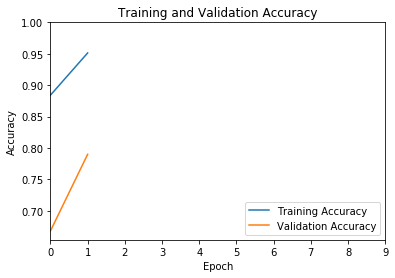

In [14]:
acc = model2_history.history['accuracy']
val_acc = model2_history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()


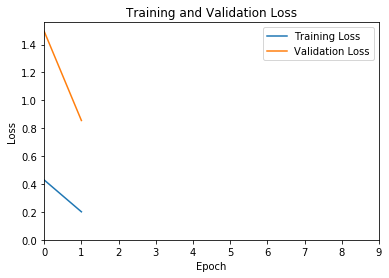

In [15]:
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlim([0,9])
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

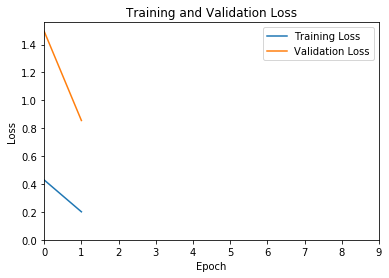

In [16]:
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlim([0,9])
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

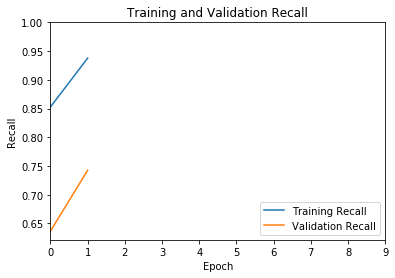

In [17]:
rec = model2_history.history['recall']
val_rec = model2_history.history['val_recall']

plt.plot(rec, label='Training Recall')
plt.plot(val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel("Recall")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.show()

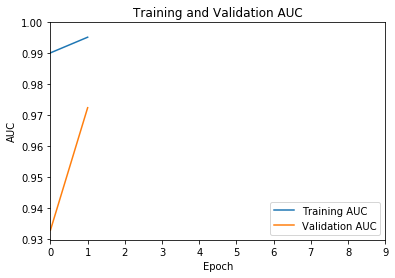

In [18]:
auc = model2_history.history['auc']
val_auc = model2_history.history['val_auc']

plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel("AUC")
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.show()

In [19]:
model2.save("model_.h5")

In [22]:
img=image.load_img('test/Basil.JPG',target_size=(224,224))
x=image.img_to_array(img)
x=x/255

import numpy as np

x=np.expand_dims(x,axis=0)


a=np.argmax(model2.predict(x), axis=1)
a

array([3])

In [24]:
class_list[3]

'Background_without_leaves'

In [23]:
@app.post("/plant")
def predict(file: UploadFile =File(...)):
    with open(file.filename, "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)
    Plant_image = Image.open(file.filename)
    # resize image

    # convert image to numpy array


    # reshape image
    image_np = np.expand_dims(img_array, axis=0)
    # predict image
    prediction =model.predict(image_np)
    prediction=np.argmax(prediction, axis=1)
    # return prediction
    prediction=index_to_label[prediction[0]]
    return{prediction}

NameError: name 'app' is not defined

In [1]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [2]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [3]:
dataset_root = "Pakplantsdata"

train_dir = os.path.join(dataset_root, "output/train")
test_dir = os.path.join(dataset_root, "output/val")

In [5]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    'output/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 16132 images belonging to 26 classes.


In [7]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())
cats

['Alstonia_Scholaris',
 'Apple',
 'Arjun',
 'Background_without_leaves',
 'Bael',
 'Basil',
 'Blueberry',
 'Cherry',
 'Chinar',
 'Corn',
 'Gauva',
 'Grape',
 'Grapevine',
 'Jamun',
 'Jatropha',
 'Lemon',
 'Mango',
 'Peach',
 'Pepper',
 'Pomegranate',
 'Pongamia_Pinnata',
 'Potato',
 'Raspberry',
 'Soybean',
 'Strawberry',
 'Tomato']

In [8]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    'output/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2009 images belonging to 26 classes.


In [9]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9412608/9406464 [==============================] - 1s 0us/step


In [10]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                33306     
Total params: 2,291,290
Trainable params: 33,306
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [12]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
150/150 [==============================] - 444s 3s/step - loss: 1.1391 - acc: 0.6973
Epoch 2/30
150/150 [==============================] - 441s 3s/step - loss: 0.3913 - acc: 0.8950
Epoch 3/30
150/150 [==============================] - 438s 3s/step - loss: 0.2684 - acc: 0.9287
Epoch 4/30
150/150 [==============================] - 436s 3s/step - loss: 0.2254 - acc: 0.9371
Epoch 5/30
150/150 [==============================] - 440s 3s/step - loss: 0.1926 - acc: 0.9458
Epoch 6/30
150/150 [==============================] - 453s 3s/step - loss: 0.1984 - acc: 0.9438
Epoch 7/30
150/150 [==============================] - 433s 3s/step - loss: 0.1688 - acc: 0.9532
Epoch 8/30
150/150 [==============================] - 451s 3s/step - loss: 0.1601 - acc: 0.9542
Epoch 9/30
150/150 [==============================] - 444s 3s/step - loss: 0.1327 - acc: 0.9621
Epoch 10/30
150/150 [==============================] - 449s 3s/step - loss: 0.1315 - acc: 0.9583
Epoch 11/30
150/150 [==================

In [13]:
model.evaluate(test_data)

63/63 [==============================] - 151s 2s/step - loss: 0.0796 - acc: 0.9771


[0.07961753564369348, 0.97710305]

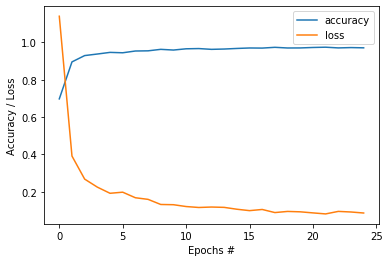

In [15]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["acc"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [16]:
model.save("mob_model.h5")

In [17]:
model.save_weights("NMT_model_weight.tf",save_format='tf')

In [18]:
model.load_weights

<bound method Model.load_weights of <tensorflow.python.keras.engine.training.Model object at 0x7f90bc2076d8>>

In [21]:
    model_config = { "class_name": "Model",
                     "config":model.get_config()
                     }

    with open(os.path.join('models', "model_config.yaml"), "w") as file:
        file.write(model.to_yaml())

    model.save_weights(os.path.join('models', "model_weights.hdf5"))


In [22]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

NameError: name 'json' is not defined